In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms.tree.mst import SpanningTreeIterator

from itertools import product

from query_graphs.query_graphs import QueryGraphs

query_graph = QueryGraphs().get_graph_7(6)

n_joins = len(query_graph.edges) - len(nx.cycle_basis(query_graph))
max_number_of_levels = n_joins
print(max_number_of_levels)
levels = range(max_number_of_levels)
variables = set()
tables = query_graph.nodes()

cardinality = {}
for node in query_graph.nodes(data=True):
    cardinality[node[0]] = node[1]['cardinality']

selectivity = {}
for edge in query_graph.edges(data=True):
    selectivity[(edge[0], edge[1])] = edge[2]['selectivity']

5


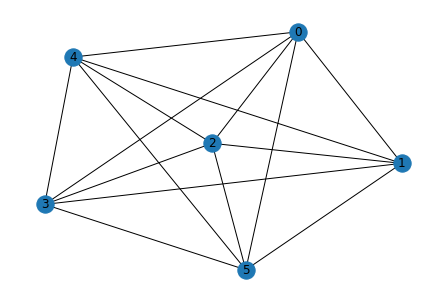

In [2]:
nx.draw(query_graph, with_labels=True)

In [3]:
def create_variable_pairs(query_graph, level, max_level):
    variables = set()
    
    for edge in query_graph.edges:
        
        vars = set([((edge[0], edge[1], level),)])
        
        for non_neigh in query_graph.nodes():
            if non_neigh != edge[0] and non_neigh != edge[1]:
                for neigh in query_graph.neighbors(non_neigh):
                    if neigh != edge[0] and neigh != edge[1]:
                        v = tuple(sorted([non_neigh, neigh]) + [level])
                        current_vars = (v, (edge[0], edge[1], level))
                        vars.add(current_vars)
                        current_vars = (v, (edge[0], edge[1], level))
                        vars.add(current_vars)
        
        variables.update(vars)
        
        if level < max_level:
        
            for neigh in query_graph.neighbors(edge[0]):
                if neigh != edge[1] and neigh != edge[0]:
                    v = tuple(sorted([edge[0], neigh]) + [level + 1])
                    current_vars = (v, (edge[0], edge[1], level))
                    vars.add(current_vars)
                    
            for neigh in query_graph.neighbors(edge[1]):
                if neigh != edge[0] and neigh != edge[1]:
                    v = tuple(sorted([edge[1], neigh]) + [level + 1])
                    current_vars = (v, (edge[0], edge[1], level))
                    vars.add(current_vars)
                
            variables.update(vars)
    
    return variables

In [4]:
level_vars = {}
for level in levels:
    level_vars[level] = create_variable_pairs(query_graph, level, max_number_of_levels - 1)

In [5]:
final_variables = {}

for key in level_vars:
    new_variables = []
    if key > 0:
        print("Number of options last round: ", len(final_variables[key - 1]))
    print("Number of options this round: ", len(level_vars[key]))
    for value in level_vars[key]:
        new_joins = set([(x[0], x[2]) for x in value]).union(set([(x[1], x[2]) for x in value]))
        new_tables = set([x[0] for x in value]).union(set([x[1] for x in value]))
        variabl = frozenset(value)
        
        if key == 0:
            #print(value)
            new_variables.append((variabl, new_tables))
        else:
            for v, tables in final_variables[key - 1]:
                
                if len(v) == max_number_of_levels:
                    continue
                
                new_steps = set([x[2] for x in value]).union(set([x[2] for x in v]))
                if new_steps != set(range(max(new_steps) + 1)):
                    continue
                
                old_joins = set([(x[0], x[2]) for x in v]).union(set([(x[1], x[2]) for x in v]))
                #old_tables = [x[0] for x in v] + [x[1] for x in v]
                tables_ok = True
                
                for new_join in value:
                    if new_join[0] in tables and new_join[1] in tables:
                        tables_ok = False
                        break
                        
                for old_join in v:
                    if old_join[0] in new_tables and old_join[1] in new_tables:
                        tables_ok = False
                        break
                
                
                if len(value) == 2:
                    if value[0][2] == value[1][2]:
                        tables1 = set([value[0][0], value[0][1]])
                        tables2 = set([value[1][0], value[1][1]])
                        if len(tables1.intersection(tables)) > 0 and len(tables2.intersection(tables)) > 0:
                            tables_ok = False
                            
                
                if len(value) == 1:
                    current_step = value[0][2]
                    existing_steps = set([x[2] for x in v])
                    if current_step in existing_steps:
                        if len(set([value[0][0], value[0][1]]).intersection(tables)) > 0:
                            tables_ok = False
                            
                
                
                    
                if not tables_ok:
                    continue
                
                int1 = v.intersection(variabl)
                int2 = old_joins.intersection(new_joins)
                
                if len(int2) == 0 and len(int1) == 0:
                    new_var = v.union(variabl)
                    
                    if (2, 3, 3) in new_var and (0, 5, 2) in new_var and (3, 4, 2) in new_var and (4, 5, 0) in new_var and (0, 1, 1) in new_var:
                        print(v, variabl, new_var)
                    
                    if len(new_var) < max_number_of_levels + 1:
                        tables = set([x[0] for x in new_var] + [x[1] for x in new_var])
                        new_variables.append((new_var, tables))
                elif len(int2) == 1 and len(int1) == 1:
                    new_var = v.union(variabl)
                    if len(new_var) < max_number_of_levels + 1:
                        new_variables.append(new_var)
                
    final_variables[key] = new_variables



Number of options this round:  225
Number of options last round:  225
Number of options this round:  225
Number of options last round:  12630
Number of options this round:  225
frozenset({(0, 1, 1), (0, 5, 2), (4, 5, 0), (1, 2, 0)}) frozenset({(2, 3, 3), (3, 4, 2)}) frozenset({(2, 3, 3), (0, 5, 2), (3, 4, 2), (1, 2, 0), (4, 5, 0), (0, 1, 1)})
frozenset({(0, 5, 2), (4, 5, 0), (0, 1, 1)}) frozenset({(2, 3, 3), (3, 4, 2)}) frozenset({(2, 3, 3), (0, 5, 2), (3, 4, 2), (4, 5, 0), (0, 1, 1)})
frozenset({(0, 1, 1), (0, 5, 2), (4, 5, 0), (2, 5, 1)}) frozenset({(2, 3, 3), (3, 4, 2)}) frozenset({(2, 3, 3), (0, 5, 2), (2, 5, 1), (3, 4, 2), (4, 5, 0), (0, 1, 1)})
frozenset({(0, 1, 1), (0, 5, 2), (4, 5, 0), (1, 2, 0)}) frozenset({(2, 3, 3), (3, 4, 2)}) frozenset({(2, 3, 3), (0, 5, 2), (3, 4, 2), (1, 2, 0), (4, 5, 0), (0, 1, 1)})
Number of options last round:  80010
Number of options this round:  225
Number of options last round:  69840
Number of options this round:  105


In [6]:
final_variables = set([value[0] for key in final_variables for value in final_variables[key]])
print(len(final_variables))

152370


In [7]:
for i, var in enumerate(final_variables):
    if i < 10:
        print(var)
    #if len(var) == 5:
    #    print(var)
    

frozenset({(2, 5, 4), (3, 4, 0), (0, 1, 2), (1, 2, 3), (1, 4, 1)})
frozenset({(2, 3, 3), (0, 5, 2), (3, 4, 2), (4, 5, 0), (0, 1, 1)})
frozenset({(2, 5, 2), (2, 4, 0), (1, 5, 3), (0, 2, 4), (2, 3, 1)})
frozenset({(1, 4, 4), (3, 5, 3), (0, 2, 2), (4, 5, 0), (2, 5, 1)})
frozenset({(1, 5, 1), (4, 5, 3), (0, 3, 2), (2, 3, 0)})
frozenset({(2, 4, 0), (1, 3, 3), (1, 4, 2), (4, 5, 1), (0, 4, 4)})
frozenset({(3, 5, 2), (2, 3, 3), (1, 4, 4), (0, 5, 1), (0, 4, 0)})
frozenset({(0, 2, 1), (3, 4, 0), (2, 4, 2), (1, 5, 0)})
frozenset({(2, 3, 1), (1, 5, 3), (0, 5, 4), (1, 3, 0), (3, 4, 2)})
frozenset({(1, 3, 2), (0, 3, 1), (2, 3, 4), (2, 4, 3), (3, 5, 0)})
